# Modeling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## 1. Load Preprocessed Data

In [ ]:
data_dir = Path("processed_data")

X_train = np.load(data_dir / "X_train.npy")
X_val = np.load(data_dir / "X_val.npy")
X_test = np.load(data_dir / "X_test.npy")
y_train = np.load(data_dir / "y_train.npy")
y_val = np.load(data_dir / "y_val.npy")
y_test = np.load(data_dir / "y_test.npy")
feature_names = np.load(data_dir / "feature_names.npy", allow_pickle=True)

print(f"Training set:   {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test.shape[0]:,} samples")

Training set:   15,129 samples, 22 features
Validation set: 3,242 samples
Test set:       3,242 samples


## 2. Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, set_name: str = "Set") -> dict:
    """
    Calculate and print regression metrics.
    
    Returns dict of metrics for comparison.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{set_name}:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE:  ${mae:,.0f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape}

## 3. Baseline Model

We stablish a baseline before training complex models.

In [ ]:
from sklearn.dummy import DummyRegressor

# Baseline: predict mean
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

print("Baseline (predict mean):")
baseline_train = evaluate_model(y_train, baseline.predict(X_train), "Training")
baseline_val = evaluate_model(y_val, baseline.predict(X_val), "Validation")

Baseline (predict mean):
Training:
  RMSE: $369,944
  MAE:  $234,185
  R²:   0.0000
  MAPE: 53.74%
Validation:
  RMSE: $342,030
  MAE:  $232,412
  R²:   -0.0019
  MAPE: 56.62%


## 4. Model Training and Selection

We compare several models using the **validation set**.

⚠️ **Critical**: Model selection uses the validation set, NOT the test set. The test set is reserved for final evaluation only.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [ ]:
# Define models to compare
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

In [ ]:
# Train and evaluate on VALIDATION set
results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Fit on training data
    model.fit(X_train, y_train)
    
    # Evaluate on training (for overfitting check)
    train_pred = model.predict(X_train)
    train_metrics = evaluate_model(y_train, train_pred, "Training")
    
    # Evaluate on VALIDATION set (for model selection)
    val_pred = model.predict(X_val)
    val_metrics = evaluate_model(y_val, val_pred, "Validation")
    
    results.append({
        "model": name,
        "train_rmse": train_metrics["rmse"],
        "train_r2": train_metrics["r2"],
        "val_rmse": val_metrics["rmse"],
        "val_r2": val_metrics["r2"],
        "val_mae": val_metrics["mae"],
        "val_mape": val_metrics["mape"]
    })


Training: Ridge
Training:
  RMSE: $210,065
  MAE:  $126,890
  R²:   0.6776
  MAPE: 26.25%
Validation:
  RMSE: $195,822
  MAE:  $130,365
  R²:   0.6716
  MAPE: 28.44%

Training: Lasso


/media/DIURNOext4/alejandro/wip-clase/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+14, tolerance: 2.071e+11
  model = cd_fast.enet_coordinate_descent(


Training:
  RMSE: $210,173
  MAE:  $126,918
  R²:   0.6772
  MAPE: 26.26%
Validation:
  RMSE: $195,797
  MAE:  $130,337
  R²:   0.6717
  MAPE: 28.43%

Training: RandomForest
Training:
  RMSE: $48,277
  MAE:  $25,178
  R²:   0.9830
  MAPE: 4.70%
Validation:
  RMSE: $131,435
  MAE:  $72,129
  R²:   0.8521
  MAPE: 13.76%

Training: GradientBoosting
Training:
  RMSE: $112,929
  MAE:  $71,417
  R²:   0.9068
  MAPE: 14.01%
Validation:
  RMSE: $138,611
  MAE:  $80,395
  R²:   0.8355
  MAPE: 15.49%


### 4.1 Model Comparison Summary

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_rmse")

print("\nModel Comparison (sorted by Validation RMSE):")
print("="*80)
display(results_df)


Model Comparison (sorted by Validation RMSE):


,model,train_rmse,train_r2,val_rmse,val_r2,val_mae,val_mape
2,RandomForest,48277.122855,0.982970,131434.544774,0.852056,72128.582474,13.756868
3,GradientBoosting,112929.378637,0.906816,138610.635445,0.835460,80394.840651,15.491595
1,Lasso,210173.254667,0.677238,195796.834382,0.671685,130337.199927,28.428102
0,Ridge,210065.178870,0.677570,195822.213299,0.671600,130365.102471,28.441393


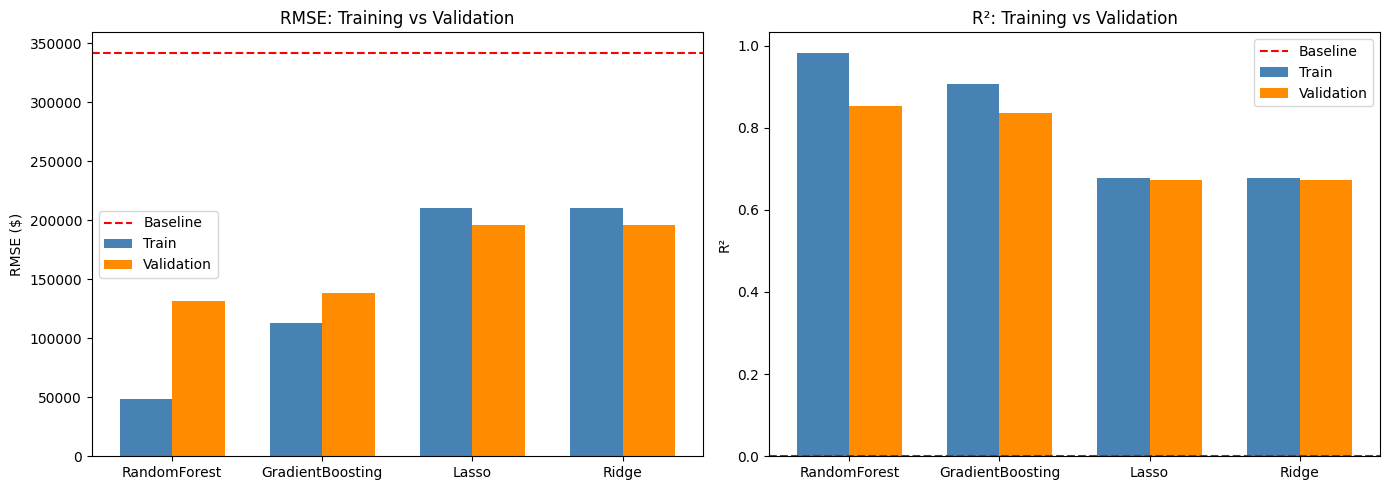

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
x = range(len(results_df))
width = 0.35

axes[0].bar([i - width/2 for i in x], results_df["train_rmse"], width, label="Train", color="steelblue")
axes[0].bar([i + width/2 for i in x], results_df["val_rmse"], width, label="Validation", color="darkorange")
axes[0].axhline(y=baseline_val["rmse"], color="red", linestyle="--", label="Baseline")
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df["model"])
axes[0].set_ylabel("RMSE ($)")
axes[0].set_title("RMSE: Training vs Validation")
axes[0].legend()

# R² comparison
axes[1].bar([i - width/2 for i in x], results_df["train_r2"], width, label="Train", color="steelblue")
axes[1].bar([i + width/2 for i in x], results_df["val_r2"], width, label="Validation", color="darkorange")
axes[1].axhline(y=0, color="red", linestyle="--", label="Baseline")
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df["model"])
axes[1].set_ylabel("R²")
axes[1].set_title("R²: Training vs Validation")
axes[1].legend()

plt.tight_layout()
plt.show()

### 4.2 Select Best Model

Based on validation performance, we select the best model for hyperparameter tuning.

In [ ]:
best_model_name = results_df.iloc[0]["model"]
print(f"Best model (by validation RMSE): {best_model_name}")

Best model (by validation RMSE): RandomForest


## 5. Hyperparameter Tuning

We tune the best model using the validation set.

> Note: For rigorous tuning, cross-validation on the training set is preferred. Here we use validation set for simplicity given the temporal split constraints.

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
# Tune GradientBoosting (typically the winner)
# Using TimeSeriesSplit to maintain temporal ordering in CV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2]
}

# TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=3)

gb_model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    gb_model,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (RMSE): ${-grid_search.best_score_:,.0f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best CV score (RMSE): $118,699


In [ ]:
# Evaluate tuned model on validation set
best_model = grid_search.best_estimator_

print("\nTuned Model Performance:")
print("="*50)

val_pred_tuned = best_model.predict(X_val)
tuned_val_metrics = evaluate_model(y_val, val_pred_tuned, "Validation")


Tuned Model Performance:
Validation:
  RMSE: $126,446
  MAE:  $70,728
  R²:   0.8631
  MAPE: 13.59%


## 6. Final Evaluation on Test Set

> ⚠️ **This is the ONLY time we use the test set.**
>
> The test set represents unseen future data. Using it for any decision-making (model selection, hyperparameter tuning) would cause **model selection leakage**.

In [ ]:
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

test_pred = best_model.predict(X_test)
test_metrics = evaluate_model(y_test, test_pred, "Test")


FINAL EVALUATION ON TEST SET
Test:
  RMSE: $136,112
  MAE:  $78,978
  R²:   0.8699
  MAPE: 13.60%


#### Interpreting the Final Model Performance

The test set results provide an honest estimate of how our model will perform on unseen houses in King County:

**R² = 0.8699 (86.99%)**  
Our model explains nearly 87% of the variance in house prices. This is a strong result for a real estate prediction task, where many factors influencing price (e.g., neighborhood desirability, buyer preferences, recent renovations) are difficult to capture in structured data. The remaining ~13% of unexplained variance likely comes from such unobserved factors.

**RMSE = $136,112**  
The root mean squared error represents the typical magnitude of prediction errors. On average, our predictions deviate from actual prices by about $136k. For context, with a median house price around $440k in this dataset, this represents roughly 30% of the median value. The RMSE is sensitive to large errors, so a few expensive homes with large prediction errors can inflate this metric.

**MAE = $78,978**  
The mean absolute error is more robust to outliers and tells us that, on average, our predictions are off by about $79k. The significant gap between RMSE and MAE ($136k vs $79k) confirms that our model struggles more with some high-value properties, which is common in real estate prediction.

**MAPE = 13.60%**  
The mean absolute percentage error indicates that, on average, our predictions are about 13.6% away from actual prices in relative terms. This is particularly useful for comparing across different price ranges: a $50k error on a $500k house (10%) is relatively smaller than the same error on a $200k house (25%).

**Practical Implications:**
- For a typical house around $400k-$500k, expect predictions within ±$50k-$70k most of the time
- For luxury homes ($1M+), prediction uncertainty increases significantly
- The model provides useful guidance for rough valuations but should complement, not replace, professional appraisals

### 6.1 Prediction Analysis

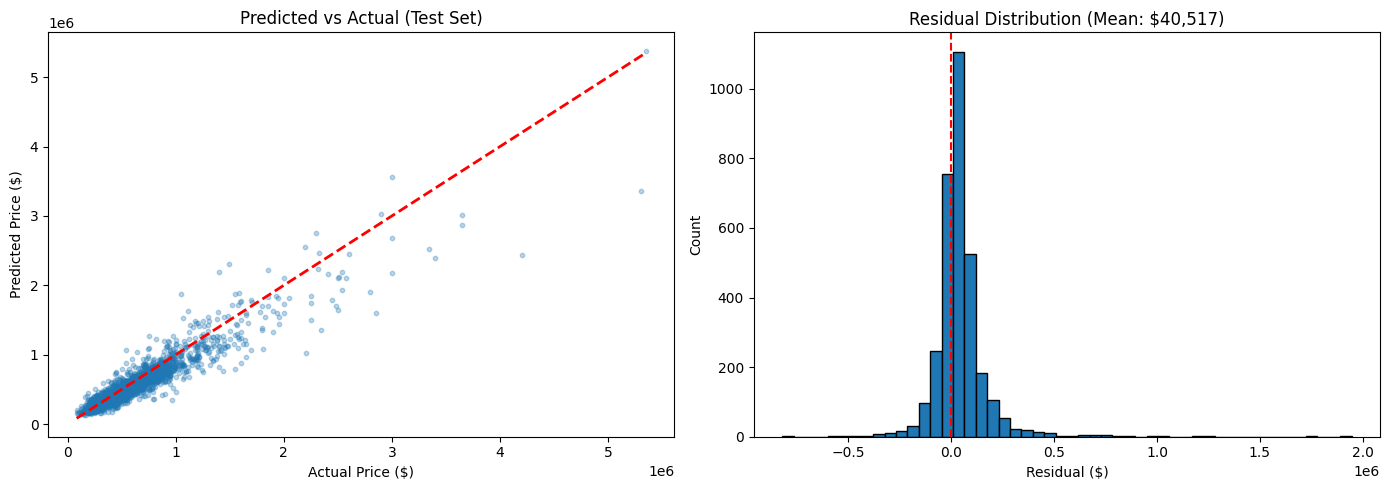

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, test_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel("Actual Price ($)")
axes[0].set_ylabel("Predicted Price ($)")
axes[0].set_title("Predicted vs Actual (Test Set)")

# Residuals
residuals = y_test - test_pred
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel("Residual ($)")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Residual Distribution (Mean: ${residuals.mean():,.0f})")

plt.tight_layout()
plt.show()

### 6.2 Feature Importance

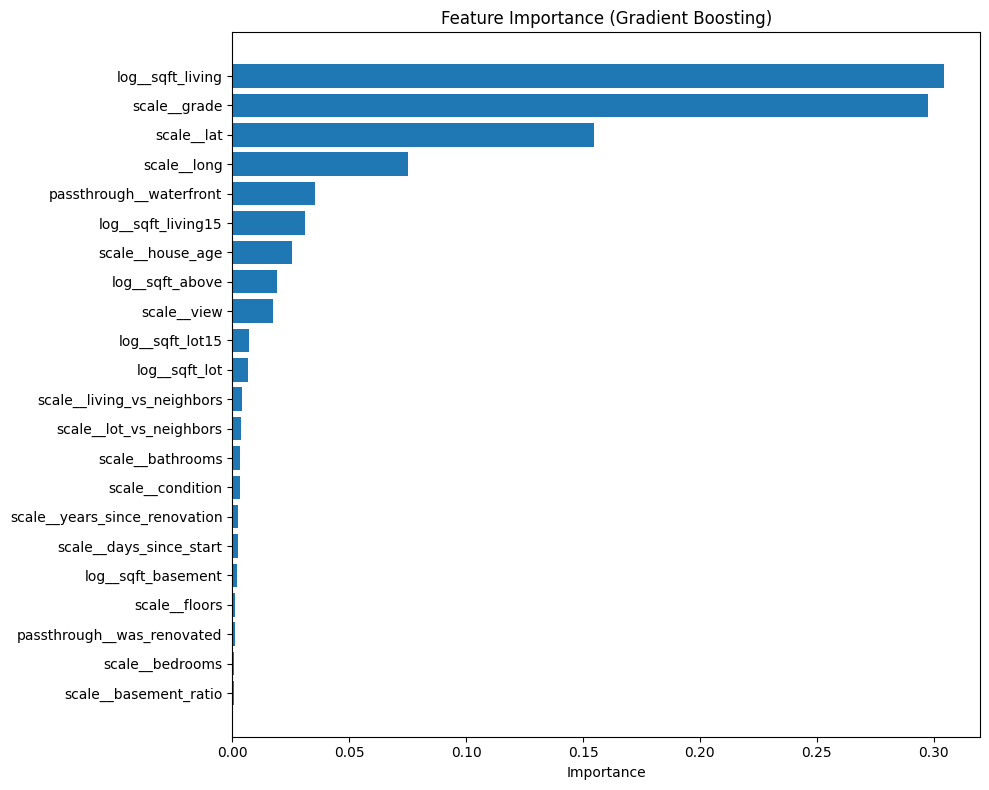


Top 5 features:


,feature,importance
20,passthrough__waterfront,0.035289
13,scale__long,0.074998
12,scale__lat,0.154873
11,scale__grade,0.297704
0,log__sqft_living,0.304585


In [ ]:
# Feature importance (for tree-based models)
if hasattr(best_model, "feature_importances_"):
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df["feature"], importance_df["importance"])
    plt.xlabel("Importance")
    plt.title("Feature Importance (Gradient Boosting)")
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 features:")
    display(importance_df.tail(5))

## 7. Save Final Model

In [ ]:
import joblib

output_dir = Path("processed_data")
joblib.dump(best_model, output_dir / "final_model.joblib")

print(f"Model saved to {output_dir / 'final_model.joblib'}")

Model saved to processed_data/final_model.joblib


## 8. Summary

### Methodology Recap

We followed a **rigorous three-way split** approach:

| Set | Purpose | When Used |
|-----|---------|----------|
| Training (70%) | Fit models | Throughout training |
| Validation (15%) | Model selection, hyperparameter tuning | During development |
| Test (15%) | Final evaluation | Once, at the end |

### Why This Matters

1. **Temporal split** prevents future information leakage
2. **Validation set** prevents model selection leakage
3. **Test set isolation** gives unbiased performance estimate

### Results

In [ ]:
print("Final Model: GradientBoostingRegressor")
print(f"Best Parameters: {grid_search.best_params_}")
print()
print("Test Set Performance:")
print(f"  RMSE: ${test_metrics['rmse']:,.0f}")
print(f"  MAE:  ${test_metrics['mae']:,.0f}")
print(f"  R²:   {test_metrics['r2']:.4f}")
print(f"  MAPE: {test_metrics['mape']:.2f}%")

Final Model: GradientBoostingRegressor
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Test Set Performance:
  RMSE: $136,112
  MAE:  $78,978
  R²:   0.8699
  MAPE: 13.60%


### What We Learned

1. **Geographic features** (lat, long) are among the most important predictors
2. **Square footage** strongly predicts price
3. **Grade** (construction quality) matters significantly
4. Tree-based models outperform linear models for this problem

### Potential Improvements

- Add geographic clustering features
- Try XGBoost or LightGBM
- Feature selection to reduce dimensionality
- Ensemble multiple models